In [5]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from PIL import Image, UnidentifiedImageError
import os
from torch.utils.data import Dataset, DataLoader
import requests
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms
from tqdm.notebook import tqdm_notebook as tqdm
from io import BytesIO

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [7]:
data = pd.read_csv('/kaggle/input/ai-of-god-3/Public_data/train.csv')

In [8]:
data['unique Id']

0        Rodrigo_00006_00
1        Rodrigo_00006_01
2        Rodrigo_00006_02
3        Rodrigo_00006_03
4        Rodrigo_00008_00
               ...       
15005    Rodrigo_00620_19
15006    Rodrigo_00620_20
15007    Rodrigo_00620_21
15008    Rodrigo_00620_22
15009    Rodrigo_00620_23
Name: unique Id, Length: 15010, dtype: object

In [9]:
li= []
a = {}
img_path = '/kaggle/input/ai-of-god-3/Public_data/train_images'
ids = list(data['unique Id'].astype(str))
for item in os.listdir(img_path):
    po=[]
    full_path = os.path.join(img_path,item)
    if(full_path.endswith('.png')):
        po.append(full_path)
        s = str(item)
        s = s[:-4]
        # a.add(s)
        idx = ids.index(s)
        label = data.iloc[idx]['transcription']
        for j in label:
            if not j in a:
                a[j] = 0
            a[j] += 1
#         img = Image.open(full_path)
#         img = np.array(img,dtype=np.float32)/255
#         if(img.shape[2]!=3):
#             continue
# #         augmented = train_transform(image=img)
# #         img = augmented['image']
        po.append(label)
        li.append(po)

In [10]:
a

{'&': 1808,
 ' ': 149316,
 'l': 39393,
 'a': 71618,
 'o': 72362,
 't': 21394,
 'r': 44352,
 'p': 11810,
 'u': 28077,
 's': 50394,
 'i': 34885,
 'e': 88221,
 'n': 43843,
 'c': 17528,
 'd': 34933,
 'y': 10622,
 'A': 5390,
 'm': 17694,
 'E': 3958,
 '_': 9,
 'f': 6938,
 'g': 8777,
 'x': 1012,
 'z': 3730,
 'ñ': 2590,
 'ī': 29,
 'q': 9984,
 'j': 1591,
 ',': 1654,
 '.': 4735,
 'Y': 454,
 'ç': 2086,
 'h': 5737,
 'C': 1901,
 'b': 6977,
 'R': 2598,
 'S': 907,
 'v': 3955,
 'P': 447,
 'L': 117,
 'J': 242,
 'N': 420,
 'á': 48,
 'V': 486,
 'D': 265,
 'í': 33,
 'Q': 210,
 '-': 300,
 '/': 704,
 'T': 365,
 'X': 53,
 'ō': 501,
 'ā': 472,
 'F': 84,
 'M': 215,
 'G': 123,
 '¶': 259,
 '1': 229,
 '–': 109,
 'ū': 26,
 'I': 70,
 'ē': 94,
 '3': 68,
 '7': 50,
 'đ': 16,
 '=': 38,
 '2': 135,
 '9': 51,
 'O': 186,
 '8': 49,
 ':': 7,
 'Ç': 17,
 '6': 50,
 '4': 63,
 '(': 27,
 'ք': 7,
 '?': 9,
 'H': 15,
 '0': 50,
 'B': 31,
 '5': 65,
 'ʠ': 7,
 ';': 4,
 ')': 3,
 'ł': 34,
 'Z': 23,
 'º': 6,
 'Ⴒ': 4,
 'ƚ': 2,
 '℣': 7,
 'þ':

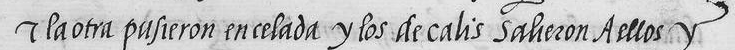

In [11]:
Image.open(li[0][0])

In [12]:
import easyocr

reader = easyocr.Reader(['es'])  # Load Spanish model
result = reader.readtext(li[0][0])

In [13]:
# Extract only the text from the result
detected_texts = [text[1] for text in result]

# Print the detected texts
detected_texts[0]

'faotra pufieron fncelada % {os decahs Salezon A cUlos'

In [14]:

li[0][1]

'& la otra pusieron en celada y los de calis salieron A ellos y'

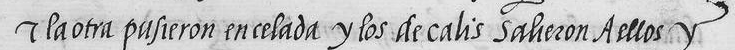

In [15]:
Image.open(li[0][0])

In [16]:
import numpy as np

def wer(reference, hypothesis):
    """
    Calculate the Word Error Rate (WER) between a reference and hypothesis sentence.
    WER is defined as the minimum number of word-level edits (insertions, deletions, substitutions)
    required to convert the hypothesis sentence into the reference sentence, divided by the total number of words in the reference.

    Parameters:
    reference (str): The ground truth sentence.
    hypothesis (str): The predicted sentence.

    Returns:
    float: The word error rate between the reference and hypothesis.
    """

    # Split the reference and hypothesis sentences into words
    reference_words = reference.split()
    hypothesis_words = hypothesis.split()

    # Create a matrix to store the distances
    d = np.zeros((len(reference_words) + 1, len(hypothesis_words) + 1), dtype=np.uint8)

    # Initialize the matrix
    for i in range(1, len(reference_words) + 1):
        d[i][0] = i
    for j in range(1, len(hypothesis_words) + 1):
        d[0][j] = j

    # Fill the matrix
    for i in range(1, len(reference_words) + 1):
        for j in range(1, len(hypothesis_words) + 1):
            if reference_words[i - 1] == hypothesis_words[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                d[i][j] = min(d[i - 1][j], d[i][j - 1], d[i - 1][j - 1]) + 1

    # The WER is the number of errors divided by the total number of words in the reference sentence
    wer_value = d[len(reference_words)][len(hypothesis_words)] / len(reference_words)

    return wer_value

# # Example usage
# reference = "this is the ground truth sentence"
# hypothesis = "this is a ground true sentence"
# wer_score = wer(reference, hypothesis)
# print(f"WER: {wer_score:.2f}")


In [17]:
wer(li[0][1],detected_texts[0])

0.9285714285714286

In [23]:
li={}
# a = set()
img_path = '/kaggle/input/ai-of-god-3/Public_data/test_images'
# ids = list(data['unique Id'].astype(str))
for itemm in os.listdir(img_path):
    poth_path = os.path.join(img_path,itemm)
    for item in os.listdir(poth_path):
        po=[]
        full_path = os.path.join(poth_path,item)
        if(full_path.endswith('.png')):
            po.append(full_path)
            s = str(itemm)
            s = 'P' + s[4:]
            s = s + '_' + str(item)[:-4]
            # a.add(s)
            # idx = ids.index(s)
            # label = data.iloc[idx]['transcription']
    #         img = Image.open(full_path)
    #         img = np.array(img,dtype=np.float32)/255
    #         if(img.shape[2]!=3):
    #             continue
    # #         augmented = train_transform(image=img)
            
    # #         img = augmented['image']
            po.append(s)
            li[po[1]] = po[0]

In [19]:
test_data = pd.read_csv('/kaggle/input/ai-of-god-3/Public_data/test.csv')
test_data['unique Id'] = test_data['unique Id'].astype(str)

In [21]:
!pip install language-tool-python

In [24]:
import language_tool_python

# Initialize the tool for Spanish
tool = language_tool_python.LanguageTool('es')

# Incorrect Spanish sentence
incorrect_text = "El casa es bonito pero no es muy cómoda."

# Check and correct the sentence
matches = tool.check(incorrect_text)
corrected_text = language_tool_python.utils.correct(incorrect_text, matches)

liii = []
for i in range(len(test_data)):
    result = reader.readtext(li[test_data.iloc[i]['unique Id']])
    detected_texts = [text[1] for text in result]

    # Incorrect Spanish sentence
    incorrect_text = detected_texts[0]
    
    # Check and correct the sentence
    matches = tool.check(incorrect_text)
    corrected_text = language_tool_python.utils.correct(incorrect_text, matches)

    liii.append(corrected_text)

In [25]:
liii

['CRO',
 '[os',
 'Que en vuelta educación lo maní',
 '[Detalle, pues me hallo bancos miles',
 'Ha rendida',
 'Densidad cal',
 '1',
 'Vuelta orfandad en tiernos años,',
 'Así pues como os di al mundo con',
 'Colores ',
 'ciencia',
 'Ahora a Dios, Y que renazcáis de mí',
 'Para él, por medio de la virtud',
 'Que 0S exportó',
 'Res (que he',
 'Ilo posible) juzgando es la más Eloy',
 'Mable herencia que',
 'en',
 'Que os censo, por ele',
 'Por el que debéis a Dios, os',
 'V',
 '[Paga en el puntual ejercicio ellos,',
 ')',
 'bendición',
 'De parce de Dios los doce más ex-',
 '[Célenles que en Maestro de Camiri',
 '[ll',
 'La:que cendra {u divina Majestad',
 'Providencia particular de vosotros,',
 '1',
 'Cu Sanco, {un consolaciones',
 'Ver sobrenatural',
 'Buena conciencia, la esperanza en la',
 'Divina misericordia, la verdadera LI',
 'Verdad, y paz interior',
 'Vuestras oraciones',
 'Favor en los trabajos, Y bendiciones',
 'Que en la Banca Escritura Promete',
 'A las círculos de codo lo se

In [62]:
# liii = []
# for i in range(10000):
#     result = reader.readtext(li[test_data.iloc[i]['unique Id']])
#     detected_texts = [text[1] for text in result]
#     liii.append(detected_texts[0])

# liii = []
# for i in range(1000):
#     result = reader.readtext(li[i][0])
#     detected_texts = [text[1] for text in result]
#     liii.append([detected_texts[0],li[i][1]])

In [65]:
pt = pd.DataFrame(liii)

In [68]:
pt.to_csv('dataset_for_gram.csv')

In [47]:
# import cv2
# import numpy as np

# # Load the greyscale image
# img = cv2.imread(li[0][0], cv2.IMREAD_GRAYSCALE)

# # Apply binary thresholding
# _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# # Find contours (these represent the characters)
# contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # Iterate through contours to group characters
# character_boxes = []
# for cnt in contours:
#     x, y, w, h = cv2.boundingRect(cnt)
#     character_boxes.append((x, y, w, h))
#     # Draw bounding box (for visualization)
#     cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

# # Sort character boxes by their x-coordinate (left-to-right reading order)
# character_boxes = sorted(character_boxes, key=lambda box: box[0])

# # You can further group characters into words based on proximity
# grouped_words = []
# current_word = [character_boxes[0]]
# for i in range(1, len(character_boxes)):
#     x1, _, w1, _ = character_boxes[i-1]
#     x2, _, w2, _ = character_boxes[i]
    
#     # Define a distance threshold to group characters into words
#     if x2 - (x1 + w1) < 10:  # 10 pixels threshold between characters
#         current_word.append(character_boxes[i])
#     else:
#         grouped_words.append(current_word)
#         current_word = [character_boxes[i]]
# if current_word:
#     grouped_words.append(current_word)

# # Visualize the grouped words
# for word in grouped_words:
#     for char in word:
#         x, y, w, h = char
#         cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

# # Show the image with bounding boxes
# cv2.imshow('Character Grouping', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [39]:
dd = pd.read_excel('/kaggle/input/ai-of-god-3/Public_data/submission.csv.xlsx')

In [43]:
dd

,unique id,prediction
0,P_1_L_1,This is a sample submission
1,P_1_L_2,This is a sample submission
2,P_1_L_3,This is a sample submission
3,P_1_L_4,This is a sample submission
4,P_1_L_5,This is a sample submission
...,...,...
163,P_7_L_20,This is a sample submission
164,P_7_L_21,This is a sample submission
165,P_7_L_22,This is a sample submission
166,P_7_L_23,This is a sample submission


In [41]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   unique id   168 non-null    object
 1   prediction  168 non-null    object
dtypes: object(2)
memory usage: 2.8+ KB
